# The LRA generator class

This is a basic notebook to show how the LRA generator is built.
Please note that this is a very intensive operation in terms of time and memory. It is recommended to use the command line interface (CLI) - the `cli_lra_generator.py` for doing any of the following operations.

In [45]:
from aqua import LRAgenerator
from aqua.util import get_machine, username

We set up some directory and folders, exploiting of `USER` environment variables. You might want to change the outdir if you want to try this notebook.

In [50]:
model = 'ERA5'
exp = 'era5'
source = 'daily'

user = username()
outdir = f'/scratch/b/{user}/test_lra/'


if get_machine()=='levante':
    outdir = f'/scratch/b/{user}/test_lra/'
elif get_machine()=='lumi':
    outdir = f'/users/{user}/scratch/test_lra/'

## A dry run
Initilize the class and retrieve the data. We are asking to go to a grid `r100` at monthly frequency. No data will be produced, we just check that everything is in place! Therefore we use `info` as loglevel to output all we need.

In [52]:
var='mtnlwrf'
resolution='r100'
frequency='monthly'
year=2020

test = LRAgenerator(model=model, exp=exp, source=source, var=var, outdir=outdir,
                     resolution=resolution, frequency=frequency, loglevel='info')
test.retrieve()
test.data = test.data.sel(time=test.data.time.dt.year == year)
test.generate_lra()

2024-02-09 19:59:17 :: lra_generator :: WARNING  -> IMPORTANT: no file will be created, this is a dry run
2024-02-09 19:59:17 :: lra_generator :: INFO     -> Variable(s) to be processed: mtnlwrf
2024-02-09 19:59:17 :: lra_generator :: INFO     -> Fixing data: True
2024-02-09 19:59:17 :: create_folder :: INFO     -> Creating folder /users/nazarova/scratch/test_lra/ERA5/era5/r100/monthly
2024-02-09 19:59:17 :: Reader :: INFO     -> Fix names in metadata is ERA5-destine-v1
2024-02-09 19:59:17 :: Reader :: INFO     -> Fix names ERA5-destine-v1 found in fixes files
2024-02-09 19:59:17 :: Reader :: INFO     -> Grid metadata is era5-r025
2024-02-09 19:59:18 :: lra_generator :: INFO     -> Accessing catalog for ERA5-era5-daily...
2024-02-09 19:59:18 :: lra_generator :: INFO     -> I am going to produce LRA at r100 resolution and monthly frequency...
2024-02-09 19:59:18 :: lra_generator :: INFO     -> Retrieving data...
2024-02-09 19:59:18 :: Reader :: INFO     -> Retrieving variables: ['mtnlwr

# A real run 

Initialize the LRA class, but setting `definitive` as true to create the actual data. Frequency is `daily` in this case.

In [53]:
frequency='daily'

test_run = LRAgenerator(model=model, exp=exp, source=source, var=var, outdir=outdir,
                            resolution=resolution, frequency=frequency, definitive=True)

Retrieve the required data: they are stored in the `data` object.

In [ ]:
test_run.retrieve()
test_run.data

Since this is a very intenstive operation, we do a hack and subselect the first month of the first year. The LRA loops on monthly data so that it can operate in a faster and less memory intensive way. We might want to move to OPA in the future, but so far simple `timmean` call are used

In [55]:
year=2020
month=1

data_per_year = test_run.data.sel(time=test_run.data.time.dt.year == year)
data_per_month = data_per_year.sel(time=data_per_year.time.dt.month == month)
test_run.data = data_per_month

Real run of the LRA, a couple of minutes to produce a monthly data for tprate

In [56]:
test_run.generate_lra()

/LUMI_TYKKY_ZOMGa5S/miniconda/envs/env1/lib/python3.11/site-packages/sparse/_coo/core.py:215: DeprecationWarning: coords should be an ndarray. This will raise a ValueError in the future.
  warnings.warn(


[##                                      ] | 5% Completed | 206.01 ms

/LUMI_TYKKY_ZOMGa5S/miniconda/envs/env1/lib/python3.11/site-packages/sparse/_coo/core.py:215: DeprecationWarning: coords should be an ndarray. This will raise a ValueError in the future.
  warnings.warn(


[########################################] | 100% Completed | 3.23 ss


There is also an option to create an entry in the catalog (`.create_catalog_entry()`), but to avoid complication and to mess up with the original catalog this is not used here. To inspect the output produced, we just use xarray:

In [57]:
formatted_month = f"{month:02d}"

import xarray as xr
file = xr.open_dataset(f"{outdir}{model}/{exp}/{resolution}/{frequency}/{var}_{exp}_{resolution}_{frequency}_{year}{formatted_month}.nc")
file

<xarray.Dataset>
Dimensions:  (time: 31, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-01-31
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    mtnlwrf  (time, lat, lon) float64 ...

From this file we can plot, for example, daily values of precipitation:

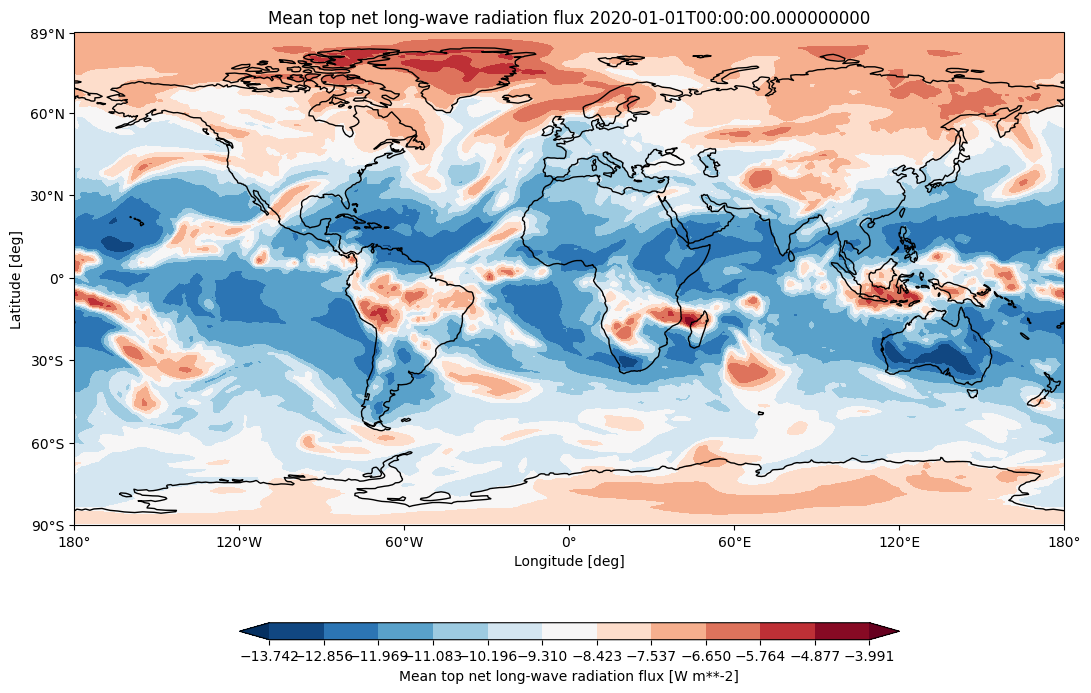

In [59]:
file[var].isel(time=0).aqua.plot_single_map()